In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.10/lib/python3.10/site-packages/traitlets/config/application.

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.10/lib/python3.10/site-packages/traitlets/config/application.

AttributeError: _ARRAY_API not found

In [3]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [5]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [6]:
# use yaml or csv input file
use_yaml = True

In [7]:
# pick an example from given three options

case_type = 'wildcat'

# case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [8]:
# where pvt located
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

# Examples

The following are the test examples.

In [9]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}

In [10]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [11]:
# the selected example for testing
case = examples[case_type]


In [12]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [13]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [14]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

## Generation of Pressure tables
### 1. Minimum input: 

In [15]:
well_csv['reservoir_pressure']

{'depth_msl': 2238, 'RP1': None, 'RP2': '+ 20', 'RP3': None}

The reservoir pressure dictionary needs to contain the `well_header`, the `co2_datum` and the `pvt_path`
It will create a table with a single scenario by default corresponding to the hydrostatic gradient.

In [16]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

Computing pressures for pure CO2 (100% CO2)
Hydrostatic pressure at reference depth 2370 is 237.15
Pressure scenario hydrostatic: Compute pressures assuming reservoir pressure is 237.15 bar at 2370.00 mTVDMSL


In [17]:
pd.DataFrame(my_pressure.pressure_scenarios).T


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,695.771401,True,111.714,237.15438,2370.0,0


### 2. Create a pressure scenario

Create a pressure scenario providing only the **MSAD** (the `from_resrv` flag has to be False )

In [18]:
my_pressure.create_pressure_scenario(name='test', from_resrvr=False, z_MSAD=500)
pd.DataFrame(my_pressure.pressure_scenarios).T


Pressure scenario test: Compute maximum pressurization needed to reach Shmin at 500 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,695.771401,True,111.714,237.15438,2370.0,0
1,test,500,False,78.530748,214.884537,2370.0,-22.269843


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir. The code assumes the reservoir depth is the same as the `co2_datum` (the `from_resrv` flag has to be True )

In [19]:
my_pressure.create_pressure_scenario(name='test2', from_resrvr=True, p_delta=50)
pd.DataFrame(my_pressure.pressure_scenarios).T

TESTING
Pressure scenario test2: Compute pressures assuming reservoir pressure is 287.15 bar at 2370.00 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,695.771401,True,111.714,237.15438,2370.0,0
1,test,500,False,78.530748,214.884537,2370.0,-22.269843
2,test2,1185.842018,True,194.78097,287.15438,2370.0,50.0


Create a pressure scenario providing only the **delta Pressure +/-** at reservoir and the reservoir depth (the `from_resrv` flag has to be True )

In [20]:
my_pressure.create_pressure_scenario(name='test3', from_resrvr=True, p_delta=70, z_resrv=2300)

pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test3: Compute pressures assuming reservoir pressure is 300.31 bar at 2300.00 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,695.771401,True,111.714,237.15438,2370.0,0
1,test,500,False,78.530748,214.884537,2370.0,-22.269843
2,test2,1185.842018,True,194.78097,287.15438,2370.0,50.0
3,test3,1394.93353,True,230.221981,300.30874,2300,70.0


Create a pressure scenario providing a pressure measurement (value) and its correspoinding depth (the `from_resrv` flag has to be True )

In [21]:
my_pressure.create_pressure_scenario(name='test4', from_resrvr=True, z_resrv=2250, p_resrv=260)
pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test4: Compute pressures assuming reservoir pressure is 260.00 bar at 2250.00 mTVDMSL


,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta
0,hydrostatic,695.771401,True,111.714,237.15438,2370.0,0
1,test,500,False,78.530748,214.884537,2370.0,-22.269843
2,test2,1185.842018,True,194.78097,287.15438,2370.0,50.0
3,test3,1394.93353,True,230.221981,300.30874,2300,70.0
4,test4,1029.337329,True,168.253425,260,2250,34.587436


# Visualization

[np.float64(2638.0), 2370.0]


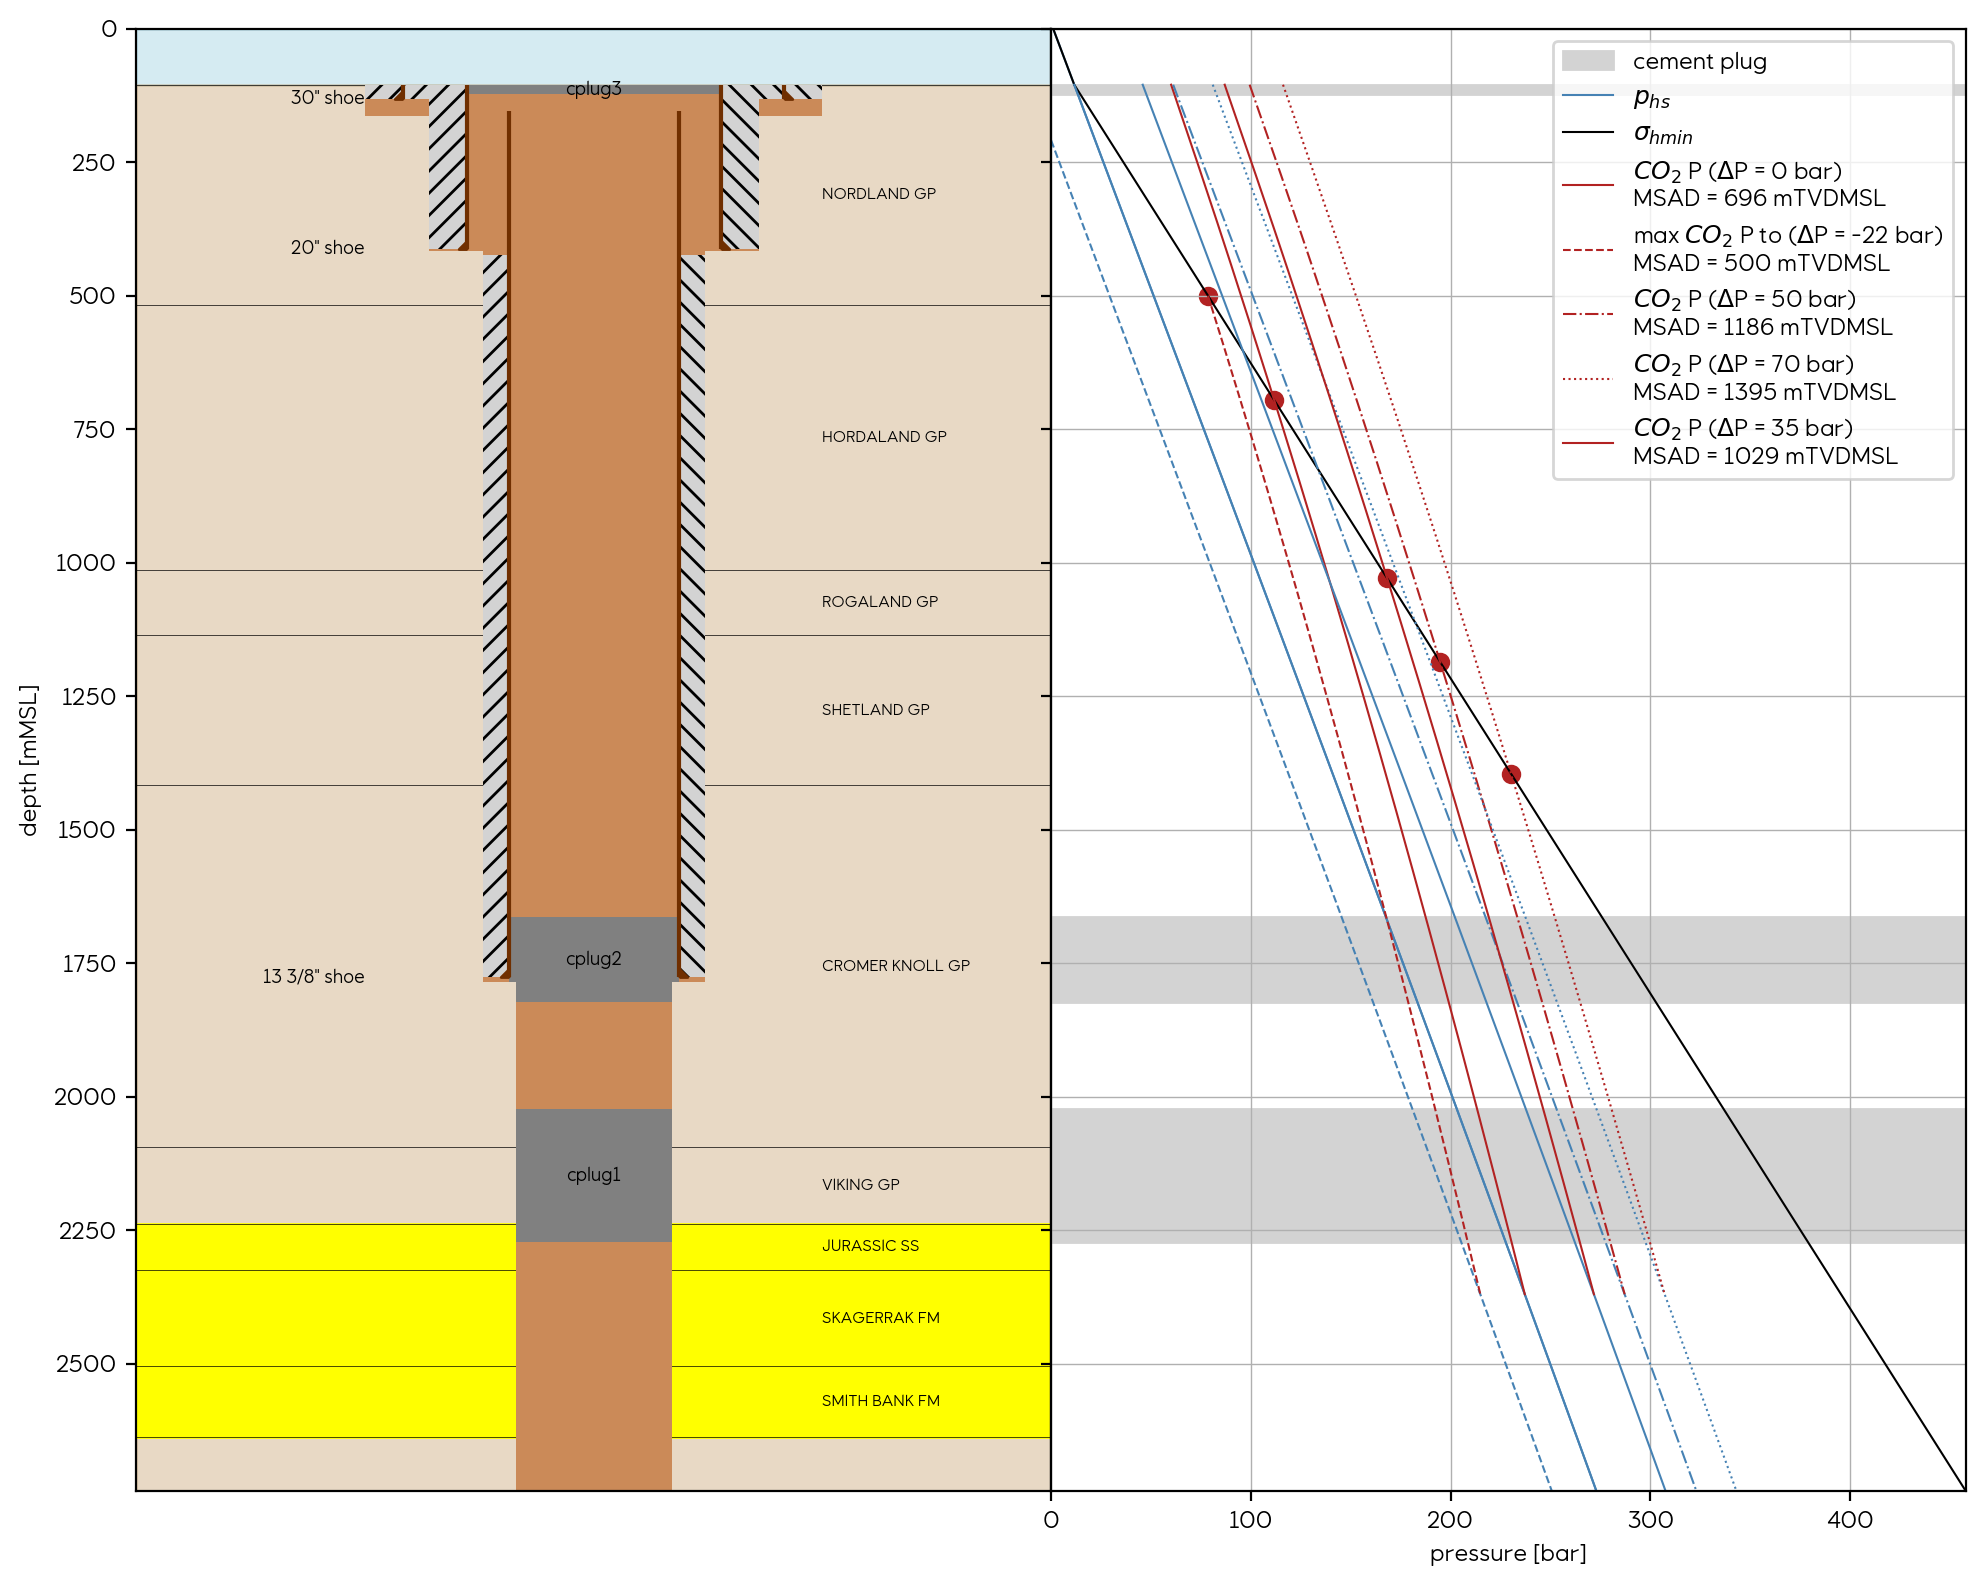

In [22]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )

fig.tight_layout()
fig.subplots_adjust(wspace=0)


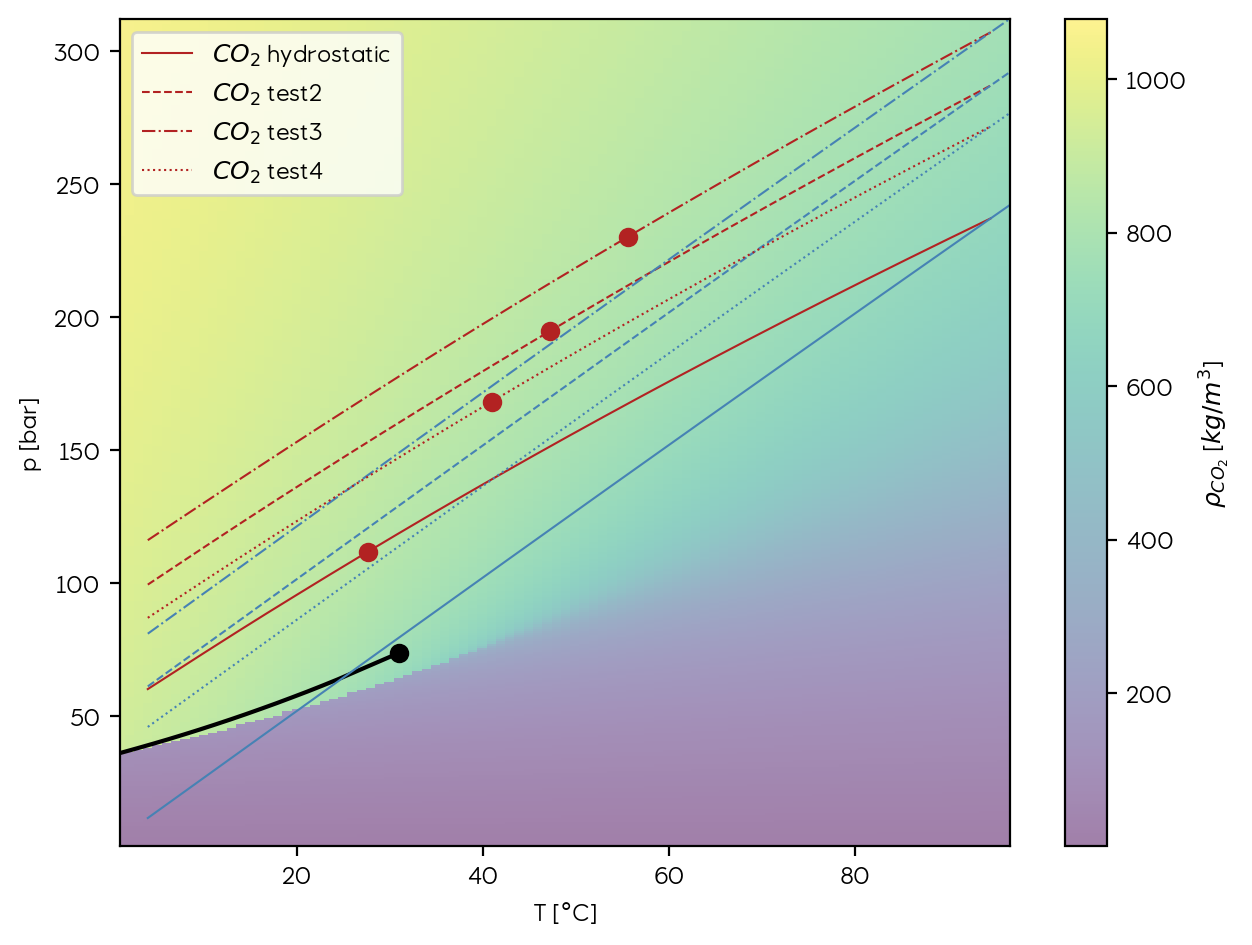

In [23]:
plot_pt(my_pressure, plot_RP=True, plot_maxP=False, plot_MSAD=True)

# CO2 Leakage

In [24]:
# pick one barrier
main_barrier = well_csv['main_barrier']
main_barrier

'cplug1'

In [25]:
# compute its leakage
barrier_leakage = my_pressure.compute_barrier_leakage(my_well, main_barrier)
barrier_leakage

barrier_perm:  [0.01, 10.0, 1000.0]


,0.01,10.00,1000.00
hydrostatic,0,0.00908,0.91965
test,0,0.00354,0.36511
test2,0,0.02174,2.18515
test3,0,0.02685,2.69676
test4,0,0.01782,1.79326
